In [43]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from geomloss import SamplesLoss


image sélectionnée : 0000.jpg
forme de l'image : (32, 32, 3)
forme du tenseur aléatoire : (32, 32, 3)


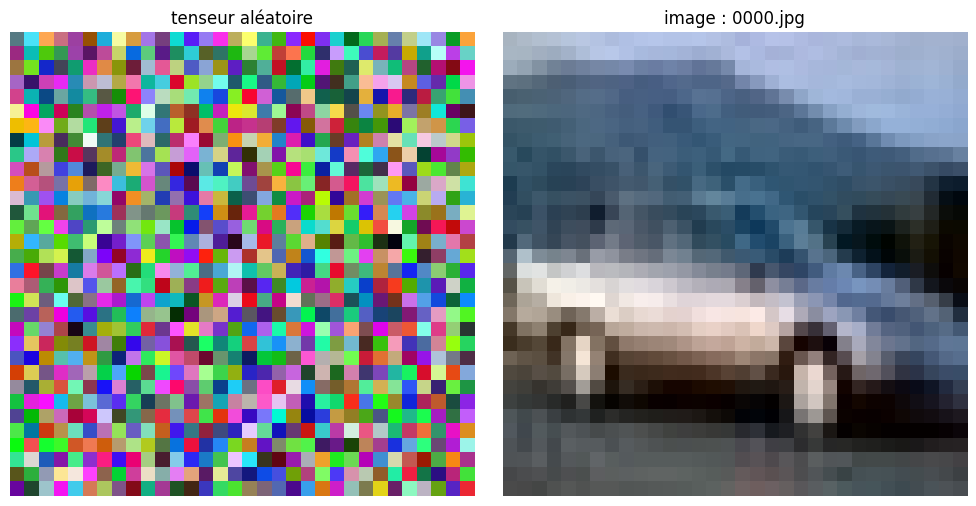

In [44]:
# we load a random image from the dataset
data_dir = '../data/cifar10/automobile'
image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

random_image_file = np.random.choice(image_files)  # we select a random image
image_path = os.path.join(data_dir, random_image_file)
image = imread(image_path)  # we load the image

print(f"image sélectionnée : {random_image_file}")
print(f"forme de l'image : {image.shape}")

# we create a random 16x16x3 tensor
random_tensor = np.random.randint(0, 256, size=(32, 32, 3), dtype=np.uint8)  # we generate random RGB values

print(f"forme du tenseur aléatoire : {random_tensor.shape}")

# we visualize both
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(random_tensor)
axes[0].set_title('tenseur aléatoire')
axes[0].axis('off')

axes[1].imshow(image)
axes[1].set_title(f'image : {random_image_file}')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [45]:
# we prepare the data for geomloss
# we reshape images to point clouds: (H*W, 3) for colors and (H*W, 2) for positions

def image_to_pointcloud(img):
    """
    we convert an image to a point cloud representation
    returns: positions (N, 2) and features/colors (N, 3)
    """
    H, W = img.shape[0], img.shape[1]  # we get height and width
    
    # we create a grid of positions
    y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    positions = np.stack([x_coords.flatten(), y_coords.flatten()], axis=1)  # we stack coordinates
    
    # we flatten the color channels
    colors = img.reshape(-1, 3)  # we reshape to (H*W, 3)
    
    return positions.astype(np.float32), colors.astype(np.float32)

# we convert both images to point clouds
pos_random, colors_random = image_to_pointcloud(random_tensor)  # we convert random tensor
pos_image, colors_image = image_to_pointcloud(image)  # we convert loaded image

print(f"nuage de points du tenseur aléatoire : {pos_random.shape}, {colors_random.shape}")
print(f"nuage de points de l'image : {pos_image.shape}, {colors_image.shape}")

# we convert to pytorch tensors
pos_random_torch = torch.from_numpy(pos_random)  # we convert positions
colors_random_torch = torch.from_numpy(colors_random)  # we convert colors
pos_image_torch = torch.from_numpy(pos_image)  # we convert positions
colors_image_torch = torch.from_numpy(colors_image)  # we convert colors

# we combine positions and colors for each point cloud
X_random = torch.cat([pos_random_torch, colors_random_torch], dim=1)  # we concatenate (N, 5): [x, y, r, g, b]
X_image = torch.cat([pos_image_torch, colors_image_torch], dim=1)  # we concatenate (N, 5): [x, y, r, g, b]

print(f"forme finale X_random : {X_random.shape}")
print(f"forme finale X_image : {X_image.shape}")


nuage de points du tenseur aléatoire : (1024, 2), (1024, 3)
nuage de points de l'image : (1024, 2), (1024, 3)
forme finale X_random : torch.Size([1024, 5])
forme finale X_image : torch.Size([1024, 5])


In [46]:
# we compute unbalanced sinkhorn distance using geomloss
# we use SamplesLoss with blur (entropic regularization) and reach (unbalanced parameter)

# we define uniform weights for both distributions
alpha = torch.ones(X_random.shape[0]) / X_random.shape[0]  # we normalize weights
beta = torch.ones(X_image.shape[0]) / X_image.shape[0]  # we normalize weights

# we create the unbalanced sinkhorn loss
# reach parameter controls the unbalanced property (larger = more unbalanced)
# blur parameter controls the entropic regularization (larger = more regularization)
loss_fn = SamplesLoss(
    loss="sinkhorn",  # we use sinkhorn divergence
    p=2,  # we use squared euclidean distance
    blur=0.05,  # we set entropic regularization parameter (epsilon)
    reach=0.5,  # we set unbalanced parameter (rho) - allows mass creation/destruction
    backend="auto"  # we let geomloss choose the best backend
)

# we compute the unbalanced sinkhorn divergence
sinkhorn_distance = loss_fn(alpha, X_random, beta, X_image)  # we compute the distance

print(f"\ndistance de sinkhorn non équilibrée : {sinkhorn_distance.item():.6f}")
print(f"\nparamètres utilisés :")
print(f"  - blur (epsilon) : 0.05")
print(f"  - reach (rho) : 0.5")
print(f"  - p (puissance métrique) : 2")
print(f"  - nombre de points source : {X_random.shape[0]}")
print(f"  - nombre de points cible : {X_image.shape[0]}")



distance de sinkhorn non équilibrée : 0.485483

paramètres utilisés :
  - blur (epsilon) : 0.05
  - reach (rho) : 0.5
  - p (puissance métrique) : 2
  - nombre de points source : 1024
  - nombre de points cible : 1024


In [47]:
# we experiment with different parameter values to compare results

reach_values = [0.5,1,10,100,1000]  # we test more unbalanced parameters
blur_values = [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2,1,10,100,1000]  # we test more regularization parameters


print("comparaison des paramètres :\n")
print(f"{'reach (rho)':<12} {'blur (epsilon)':<16} {'distance':<12}")
print("-" * 45)

results = []  # we store results for analysis

for reach in reach_values:  # we iterate over reach values
    for blur in blur_values:  # we iterate over blur values
        # we create loss function with current parameters
        loss_fn_test = SamplesLoss(
            loss="sinkhorn",
            p=2,
            blur=blur,
            reach=reach,
            backend="auto"
        )
        
        # we compute distance
        dist = loss_fn_test(alpha, X_random, beta, X_image)
        results.append((reach, blur, dist.item()))  # we store result
        
        print(f"{reach:<12.2f} {blur:<16.3f} {dist.item():<12.6f}")

# we find the configuration with minimum distance
best_config = min(results, key=lambda x: x[2])  # we get minimum distance configuration
print(f"\nmeilleure configuration : reach={best_config[0]:.2f}, blur={best_config[1]:.3f}, distance={best_config[2]:.6f}")


comparaison des paramètres :

reach (rho)  blur (epsilon)   distance    
---------------------------------------------
0.50         0.005            0.499852    
0.50         0.010            0.499407    
0.50         0.025            0.496313    
0.50         0.050            0.485483    
0.50         0.075            0.468580    
0.50         0.100            0.445488    
0.50         0.200            0.327648    
0.50         1.000            0.016396    
0.50         10.000           1.200462    
0.50         100.000          767.347473  
0.50         1000.000         942.958740  
1.00         0.005            1.999850    
1.00         0.010            1.999406    
1.00         0.025            1.996297    
1.00         0.050            1.985249    
1.00         0.075            1.967129    
1.00         0.100            1.941929    
1.00         0.200            1.781948    
1.00         1.000            0.394305    
1.00         10.000           1.278270    
1.00         100.000 

## barycentres de wasserstein

nous allons calculer des **vrais barycentres de wasserstein** en utilisant le gradient du sinkhorn pour approximer la carte de monge.


In [48]:
def pointcloud_to_image(positions, features, H=16, W=16):
    """
    we convert a point cloud back to an image
    positions: (N, 2) array of (x, y) coordinates
    features: (N, 3) array of RGB values
    returns: (H, W, 3) image
    """
    img = np.zeros((H, W, 3), dtype=np.float32)  # we initialize empty image
    
    # we fill the image with the features at their positions
    for i in range(positions.shape[0]):  # we iterate over points
        x, y = int(positions[i, 0]), int(positions[i, 1])  # we get integer coordinates
        if 0 <= x < W and 0 <= y < H:  # we check bounds
            img[y, x] = features[i]  # we set pixel value
    
    return np.clip(img, 0, 255).astype(np.uint8)  # we clip and convert to uint8


In [49]:
# we define helper utilities for wasserstein barycenters on RGB images

def _grid_positions(H: int, W: int, device: torch.device, dtype: torch.dtype) -> torch.Tensor:
    """we create a fixed grid of positions in [0, 1) x [0, 1)."""
    y_coords, x_coords = torch.meshgrid(
        torch.arange(H, dtype=dtype, device=device) / H,
        torch.arange(W, dtype=dtype, device=device) / W,
        indexing='ij'
    )
    positions = torch.stack([x_coords.flatten(), y_coords.flatten()], dim=1)  # shape (N, 2)
    return positions

def _ensure_image_shape(img: np.ndarray, H: int, W: int) -> np.ndarray:
    """we ensure the input image has shape (H, W, 3)."""
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    img = np.asarray(img)
    if img.ndim == 2:  # we duplicate channels
        img = np.stack([img] * 3, axis=-1)
    if img.shape[:2] != (H, W):
        img_uint8 = np.clip(img, 0, 255).astype(np.uint8)
        img = np.array(Image.fromarray(img_uint8).resize((W, H), Image.BILINEAR))
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def _image_channel_to_measure(img: np.ndarray, channel: int, device: torch.device, dtype: torch.dtype) -> tuple[torch.Tensor, torch.Tensor]:
    """we convert an image channel to a probability measure on the grid."""
    H, W = img.shape[:2]
    channel_values = img[:, :, channel].astype(np.float32)
    weights = torch.from_numpy(channel_values.reshape(-1)).to(device=device, dtype=dtype)
    weights = weights + 1e-6  # we avoid zero mass
    weights = weights / weights.sum().clamp(min=1e-6)  # we normalize to a probability measure
    positions = _grid_positions(H, W, device=device, dtype=dtype)
    return weights, positions

def _barycenter_positions(measures: list[tuple[torch.Tensor, torch.Tensor]], lambdas: list[float] | np.ndarray, blur: float, reach: float | None) -> tuple[torch.Tensor, torch.Tensor]:
    """we compute barycentric positions using the geomloss gradient trick."""
    lambdas = [float(lmb) for lmb in lambdas]
    weights_ref, _ = measures[0]
    H = int(np.sqrt(weights_ref.numel()))
    W = H
    device = weights_ref.device
    dtype = weights_ref.dtype
    N = weights_ref.numel()
    
    a_i = torch.ones(N, device=device, dtype=dtype) / N  # uniform reference weights
    x_i = _grid_positions(H, W, device, dtype).requires_grad_(True)
    
    if reach is None:
        loss_fn = SamplesLoss(loss="sinkhorn", p=2, blur=blur, backend="auto")
    else:
        loss_fn = SamplesLoss(loss="sinkhorn", p=2, blur=blur, reach=reach, backend="auto")
    
    models = []
    for weights, positions in measures:
        L = loss_fn(a_i, x_i, weights, positions)
        [g_i] = torch.autograd.grad(L, [x_i], create_graph=False)
        model = (x_i - g_i / a_i.view(-1, 1)).detach()
        models.append(model)
    
    bary_positions = sum(lambda_i * model for lambda_i, model in zip(lambdas, models))
    bary_weights = sum(lambda_i * weights for lambda_i, (weights, _) in zip(lambdas, measures))
    bary_weights = bary_weights / bary_weights.sum().clamp(min=1e-6)
    return bary_positions, bary_weights

def _positions_to_image(bary_positions: torch.Tensor, bary_weights: torch.Tensor, H: int, W: int) -> np.ndarray:
    """we bin barycentric samples back onto the pixel grid."""
    device = bary_positions.device
    dtype = bary_positions.dtype
    coords = bary_positions.clamp(min=0.0, max=0.9999)
    xs = (coords[:, 0] * W).floor().long()
    ys = (coords[:, 1] * H).floor().long()
    indices = ys * W + xs
    flat_img = torch.zeros(H * W, device=device, dtype=dtype)
    flat_img.index_add_(0, indices, bary_weights)
    flat_img = flat_img / flat_img.max().clamp(min=1e-6)
    flat_img = (flat_img * 255.0).clamp(0, 255)
    return flat_img.view(H, W).cpu().numpy().astype(np.uint8)

def compute_rgb_wasserstein_barycenter(target_images: list[np.ndarray], t_values: list[float], H: int | None = None, W: int | None = None, blur: float = 0.01, reach: float | None = None) -> np.ndarray:
    """we compute a wasserstein barycenter for RGB images, channel by channel."""
    if not target_images:
        raise ValueError("target_images must contain at least one image")
    H_img, W_img = target_images[0].shape[:2]
    H = H if H is not None else H_img
    W = W if W is not None else W_img
    device = torch.device("cpu")
    dtype = torch.float32
    result_channels: list[np.ndarray] = []
    
    target_images_clean = [_ensure_image_shape(img, H, W) for img in target_images]
    
    for channel in range(3):  # we process each RGB channel
        measures = []
        for img in target_images_clean:
            weights, positions = _image_channel_to_measure(img, channel, device, dtype)
            measures.append((weights, positions))
        bary_positions, bary_weights = _barycenter_positions(measures, t_values, blur, reach)
        channel_img = _positions_to_image(bary_positions, bary_weights, H, W)
        result_channels.append(channel_img)
    
    result_image = np.stack(result_channels, axis=2)
    return result_image

print("fonction de calcul de barycentre wasserstein RGB créée ✓")

fonction de calcul de barycentre wasserstein RGB créée ✓


calcul de 12 barycentres de wasserstein (par canal RGB)...


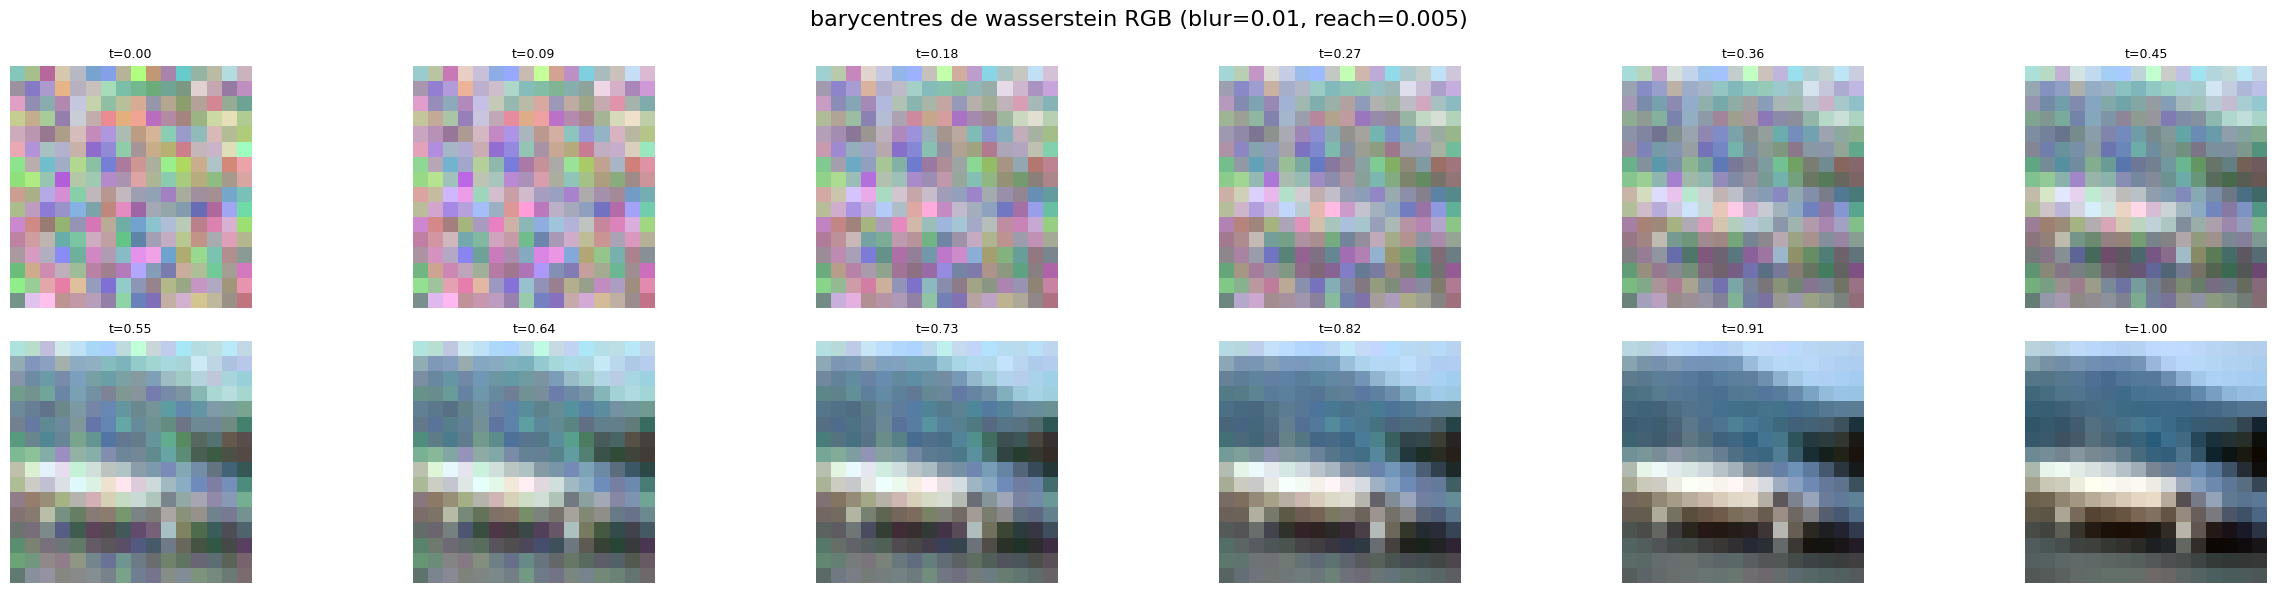


✓ interpolation par barycentres de wasserstein (par canal RGB)
t=0.0 correspond au tenseur aléatoire, t=1.0 correspond à l'image cible


In [55]:
# we visualize wasserstein barycenters for different time steps

blur_wass = 0.01  # we set blur parameter
reach_wass = 0.005  # we set reach parameter
n_steps = 12  # we create interpolation steps
t_values_wass = np.linspace(0, 1, n_steps)  # we generate time values

fig, axes = plt.subplots(2, n_steps//2, figsize=(25, 6))  # we create grid in 2 rows
axes = axes.flatten()  # we flatten for easy indexing
fig.suptitle(f'barycentres de wasserstein RGB (blur={blur_wass}, reach={reach_wass})', fontsize=16)

print(f"calcul de {n_steps} barycentres de wasserstein (par canal RGB)...")

for idx, t in enumerate(t_values_wass):  # we iterate over time steps
    # we compute wasserstein barycenter for RGB images
    img_bary = compute_rgb_wasserstein_barycenter(
        [random_tensor, image],  # we use both images as targets
        [1-t, t],  # we set interpolation weights
        H=16, W=16,  # we specify image dimensions
        blur=blur_wass,
        reach=reach_wass
    )
    
    axes[idx].imshow(img_bary)
    axes[idx].set_title(f't={t:.2f}', fontsize=9)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ interpolation par barycentres de wasserstein (par canal RGB)")
print("t=0.0 correspond au tenseur aléatoire, t=1.0 correspond à l'image cible")

calcul des barycentres wasserstein (RGB) pour différents blur et t_mid...


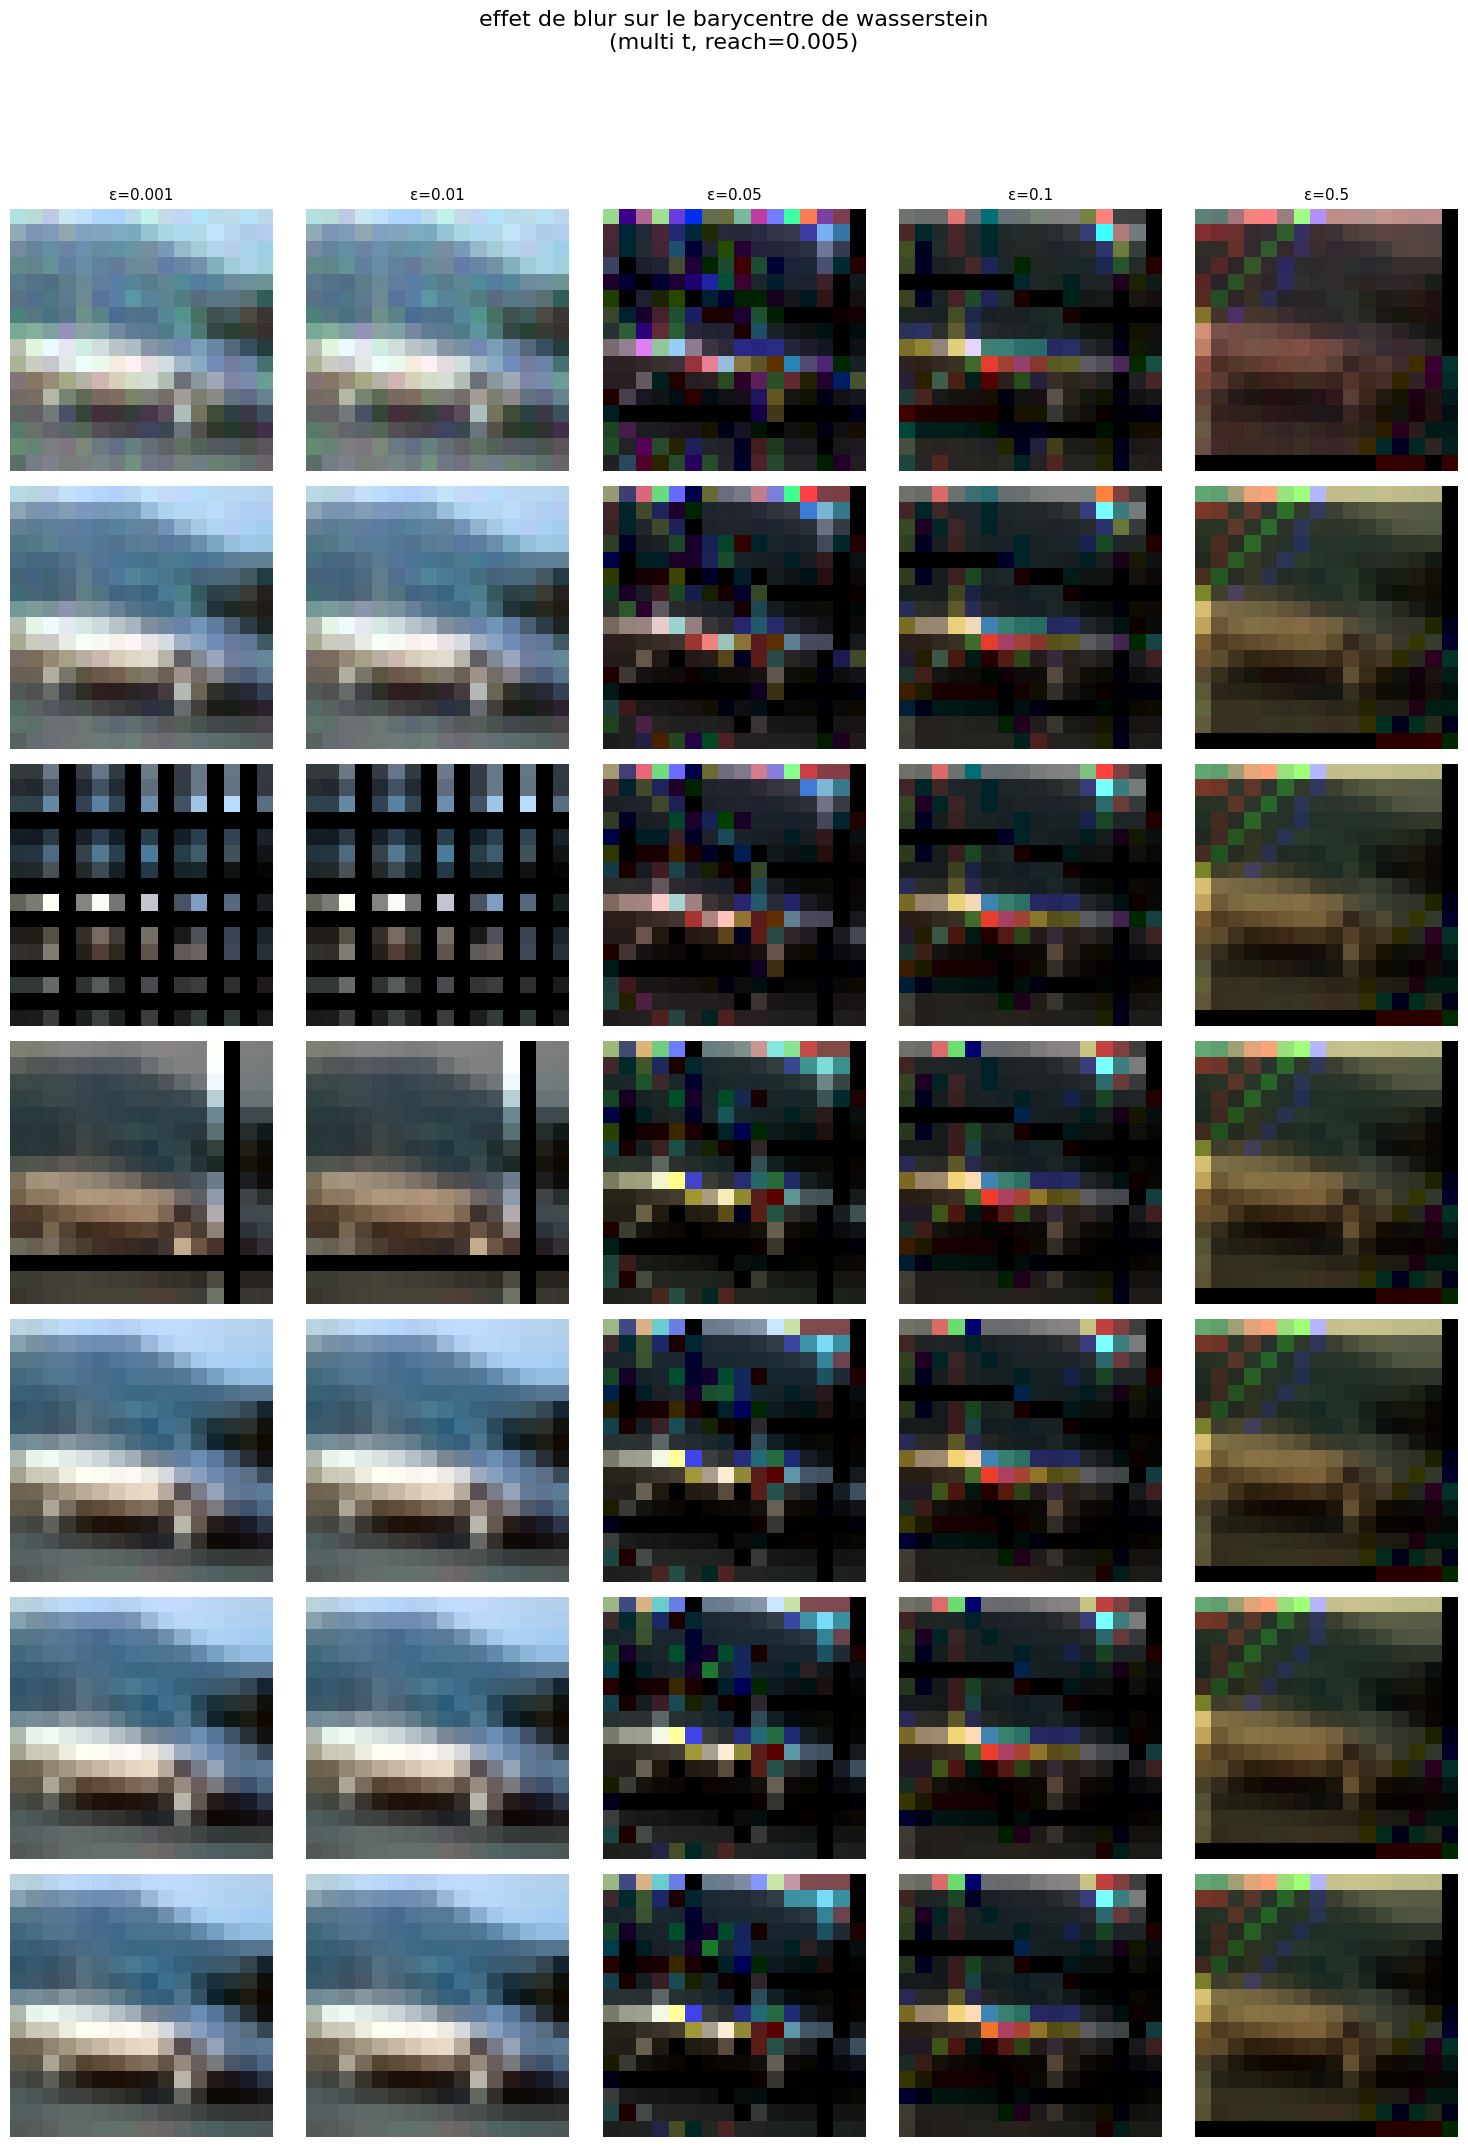


observations :
  - les images changent vraiment avec blur et t !
  - blur faible → transport très précis, détails préservés
  - blur élevé → transport plus diffus, transition plus douce
  - t proche de 1 → image presque cible
calcul des barycentres wasserstein (RGB) pour différents blur et t_mid...


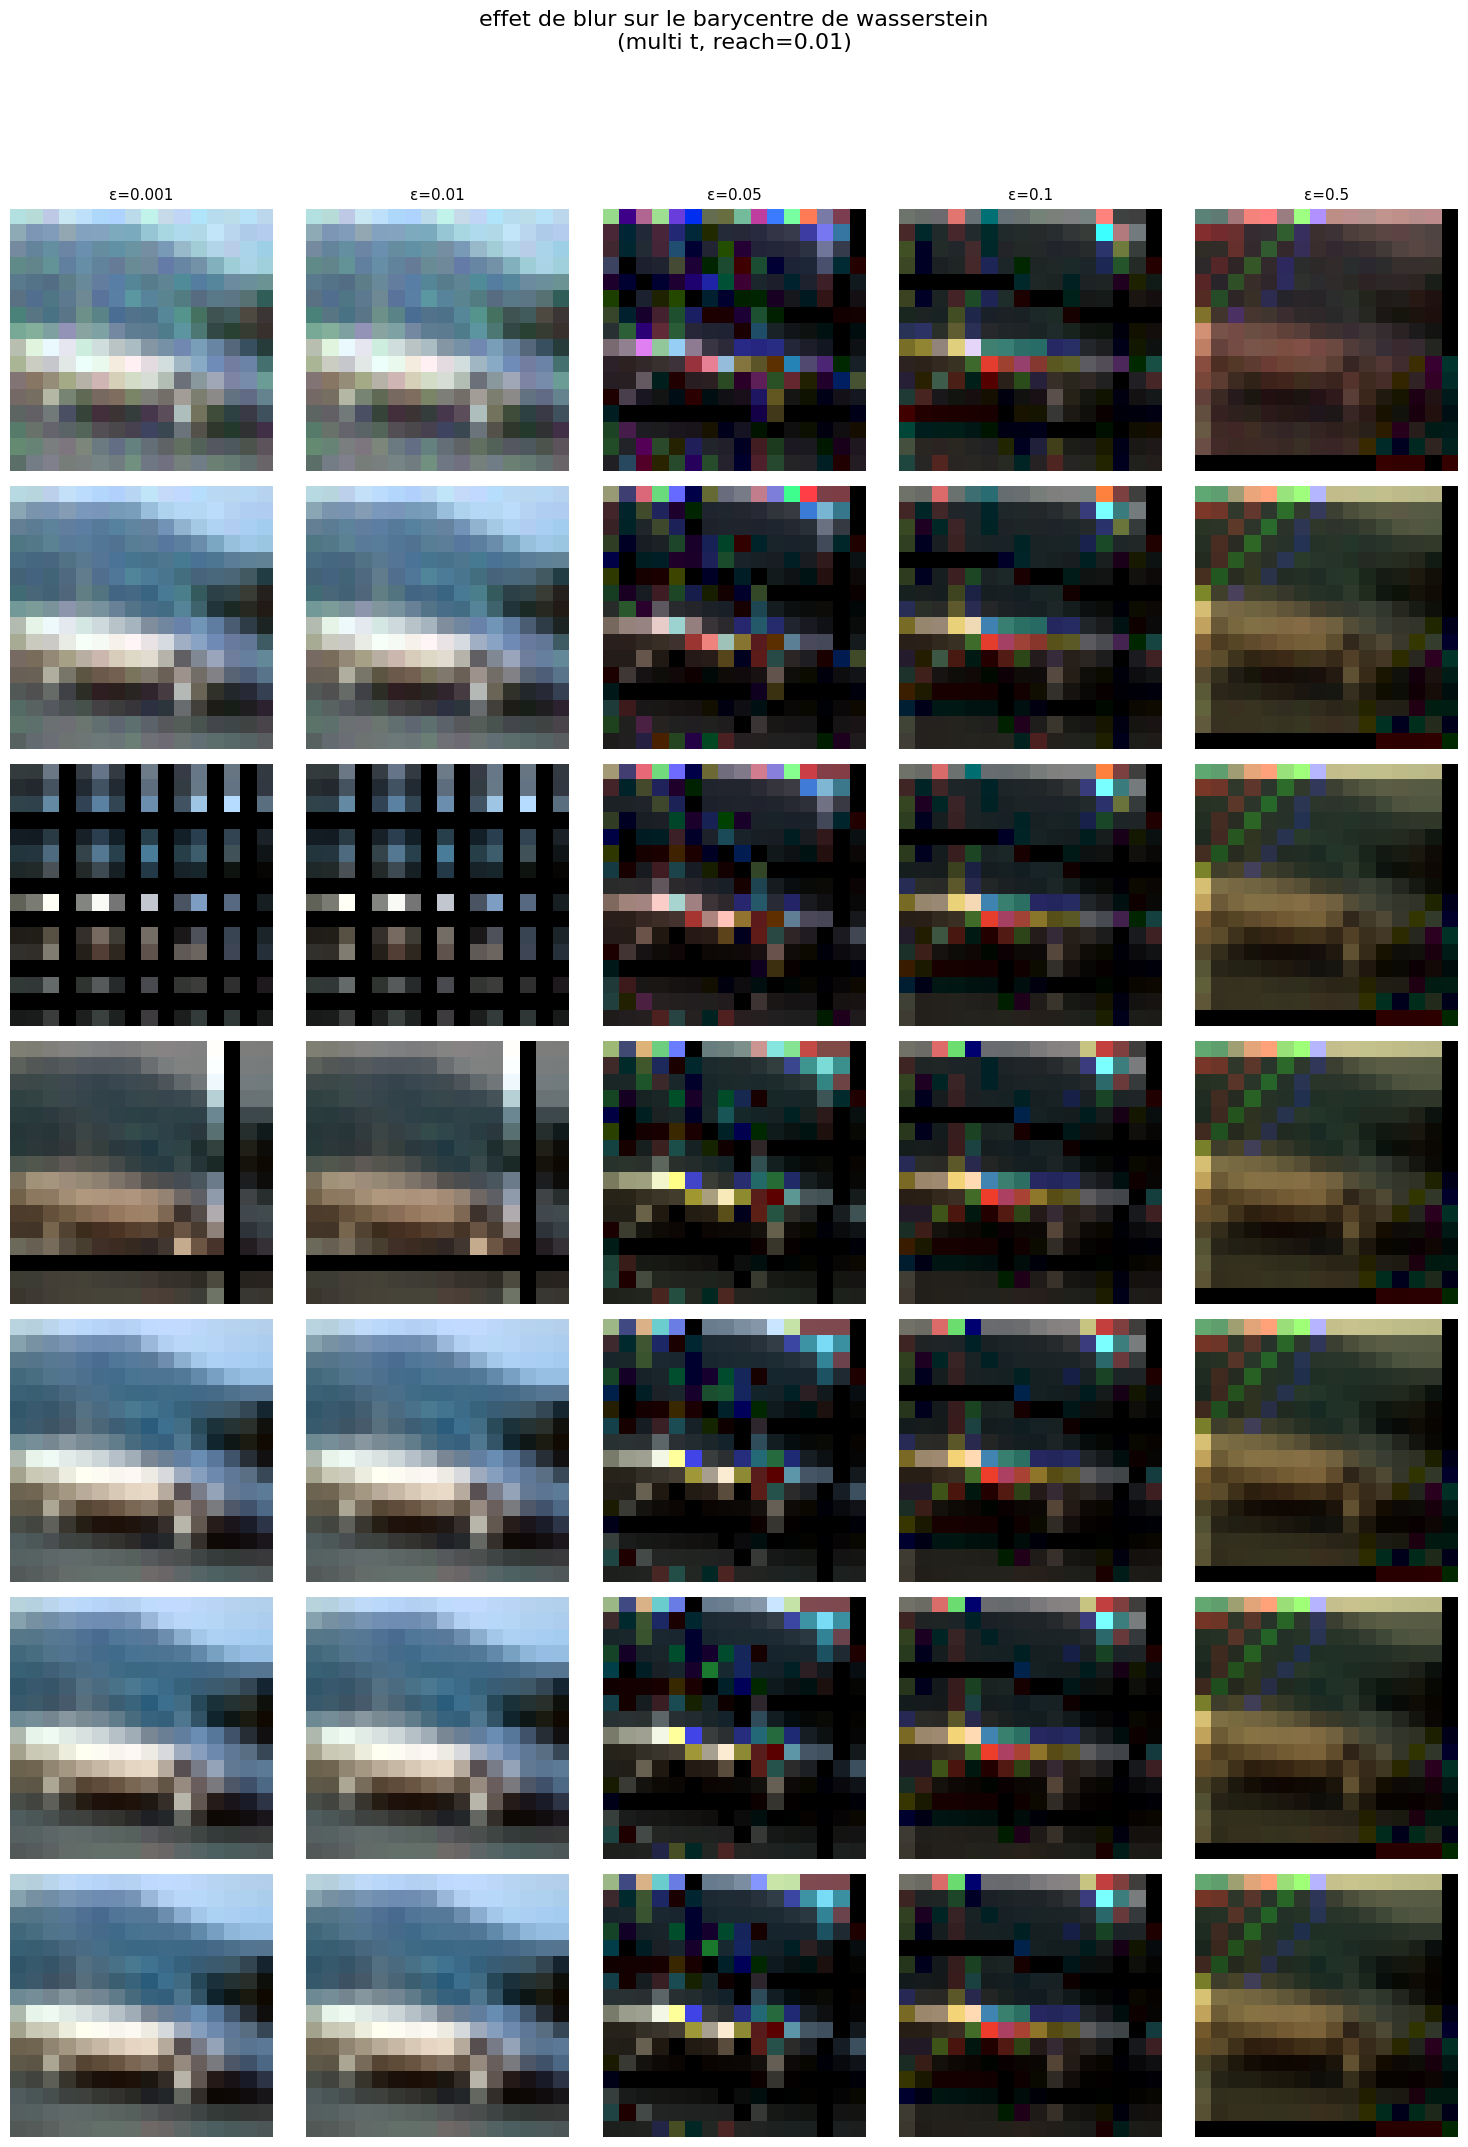


observations :
  - les images changent vraiment avec blur et t !
  - blur faible → transport très précis, détails préservés
  - blur élevé → transport plus diffus, transition plus douce
  - t proche de 1 → image presque cible
calcul des barycentres wasserstein (RGB) pour différents blur et t_mid...


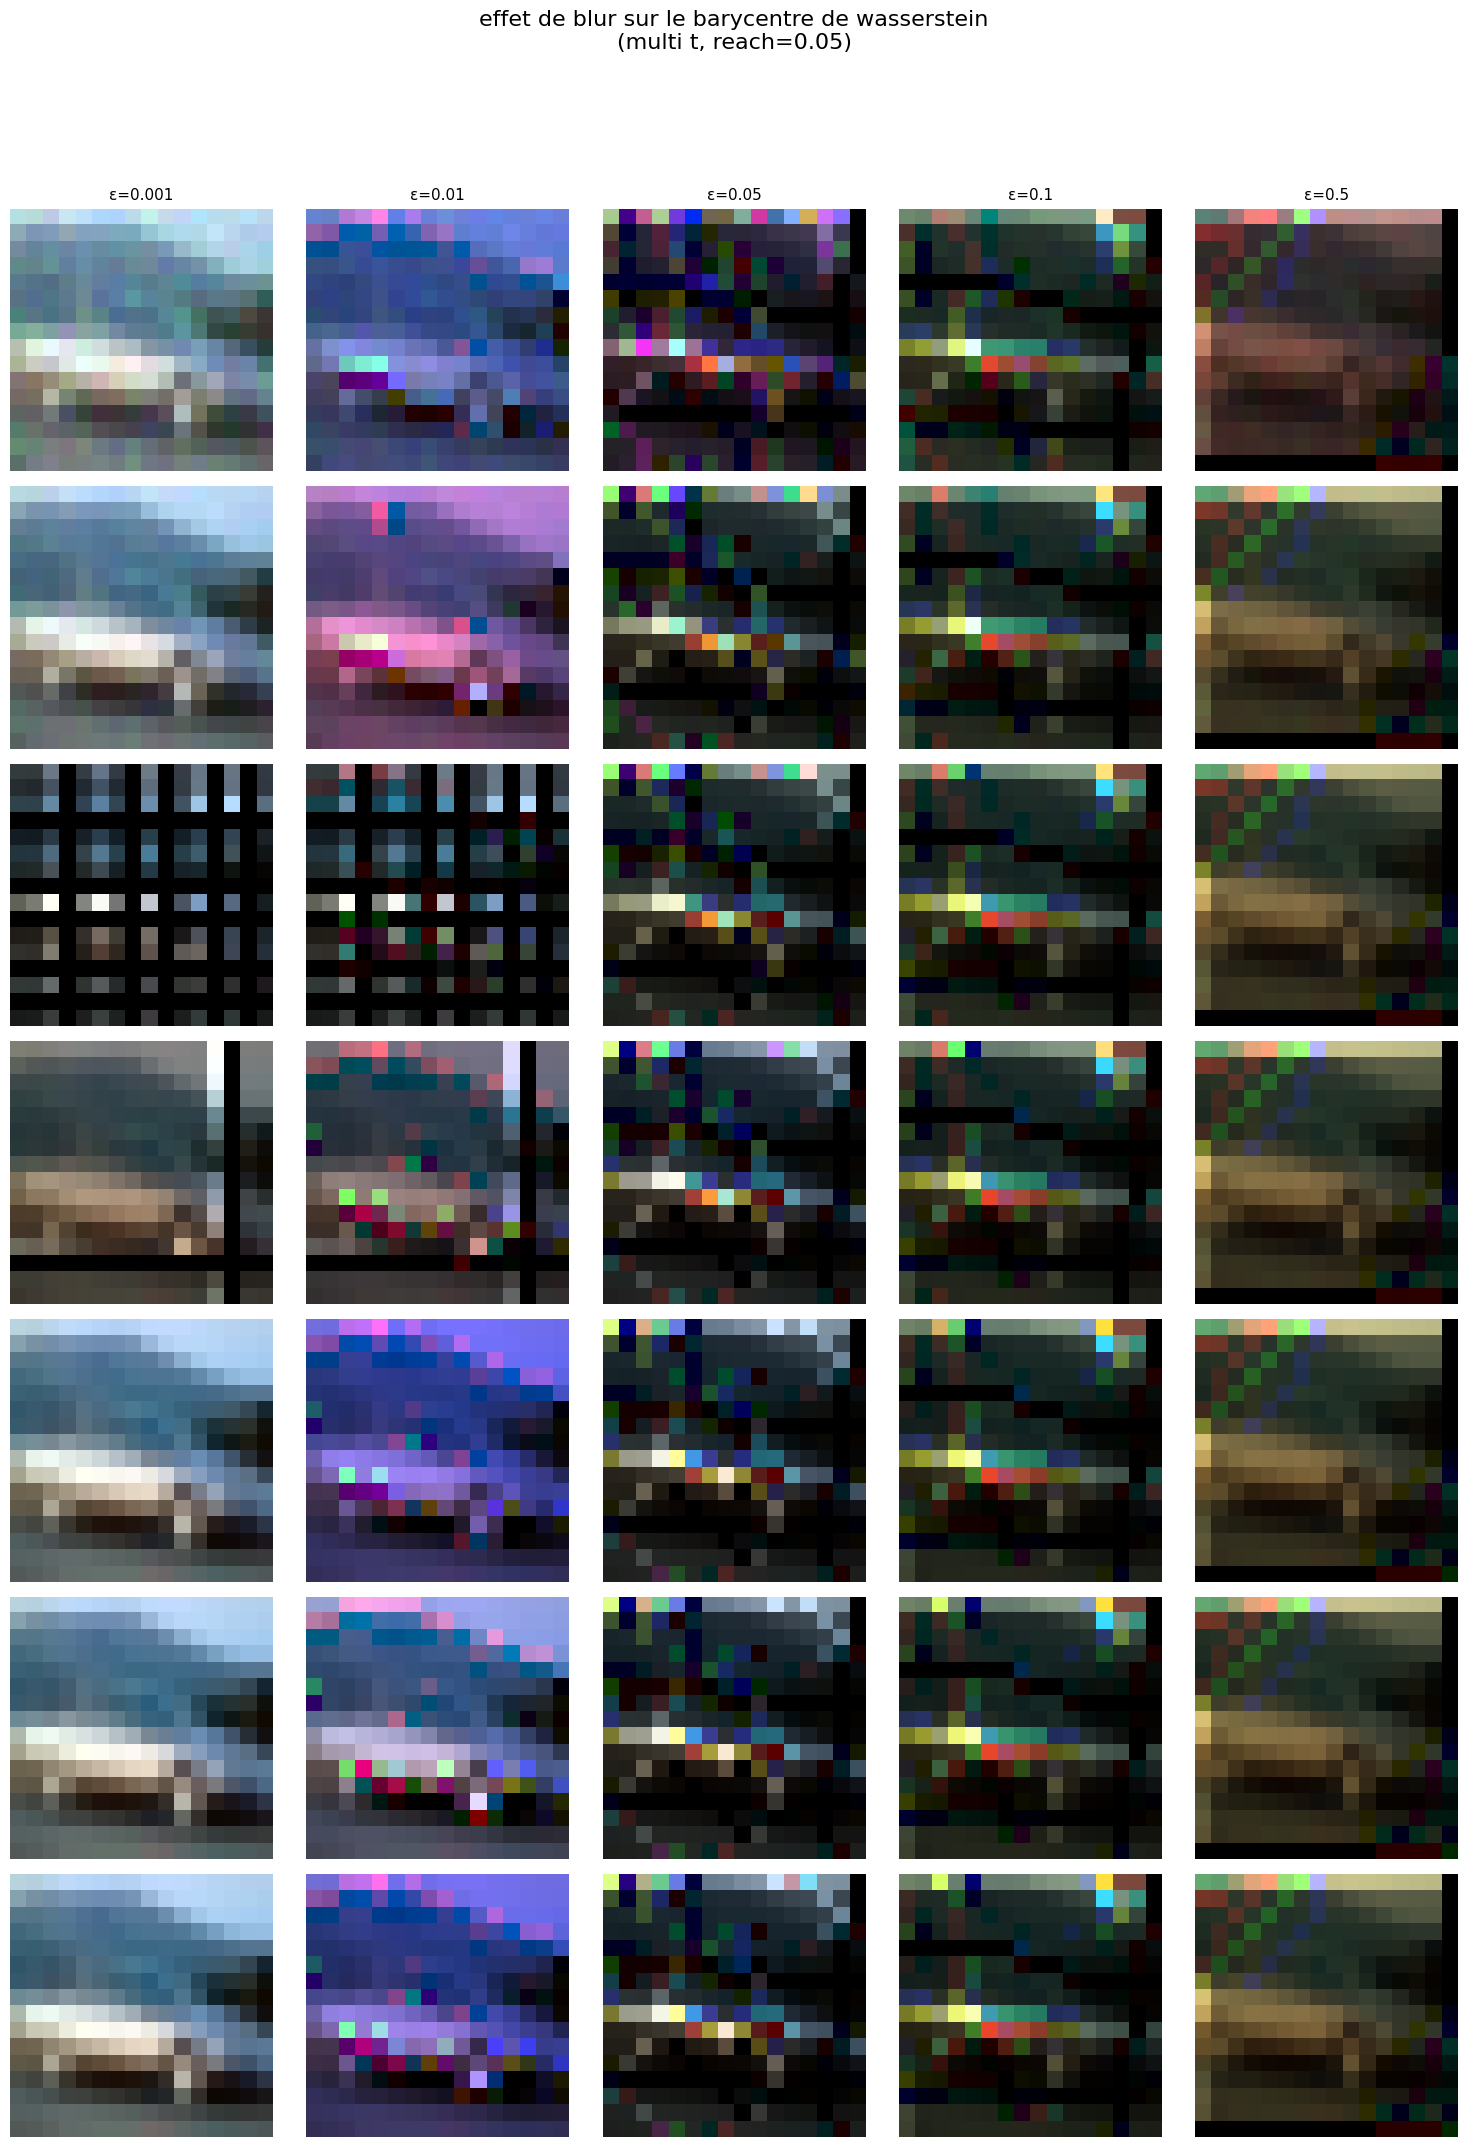


observations :
  - les images changent vraiment avec blur et t !
  - blur faible → transport très précis, détails préservés
  - blur élevé → transport plus diffus, transition plus douce
  - t proche de 1 → image presque cible
calcul des barycentres wasserstein (RGB) pour différents blur et t_mid...


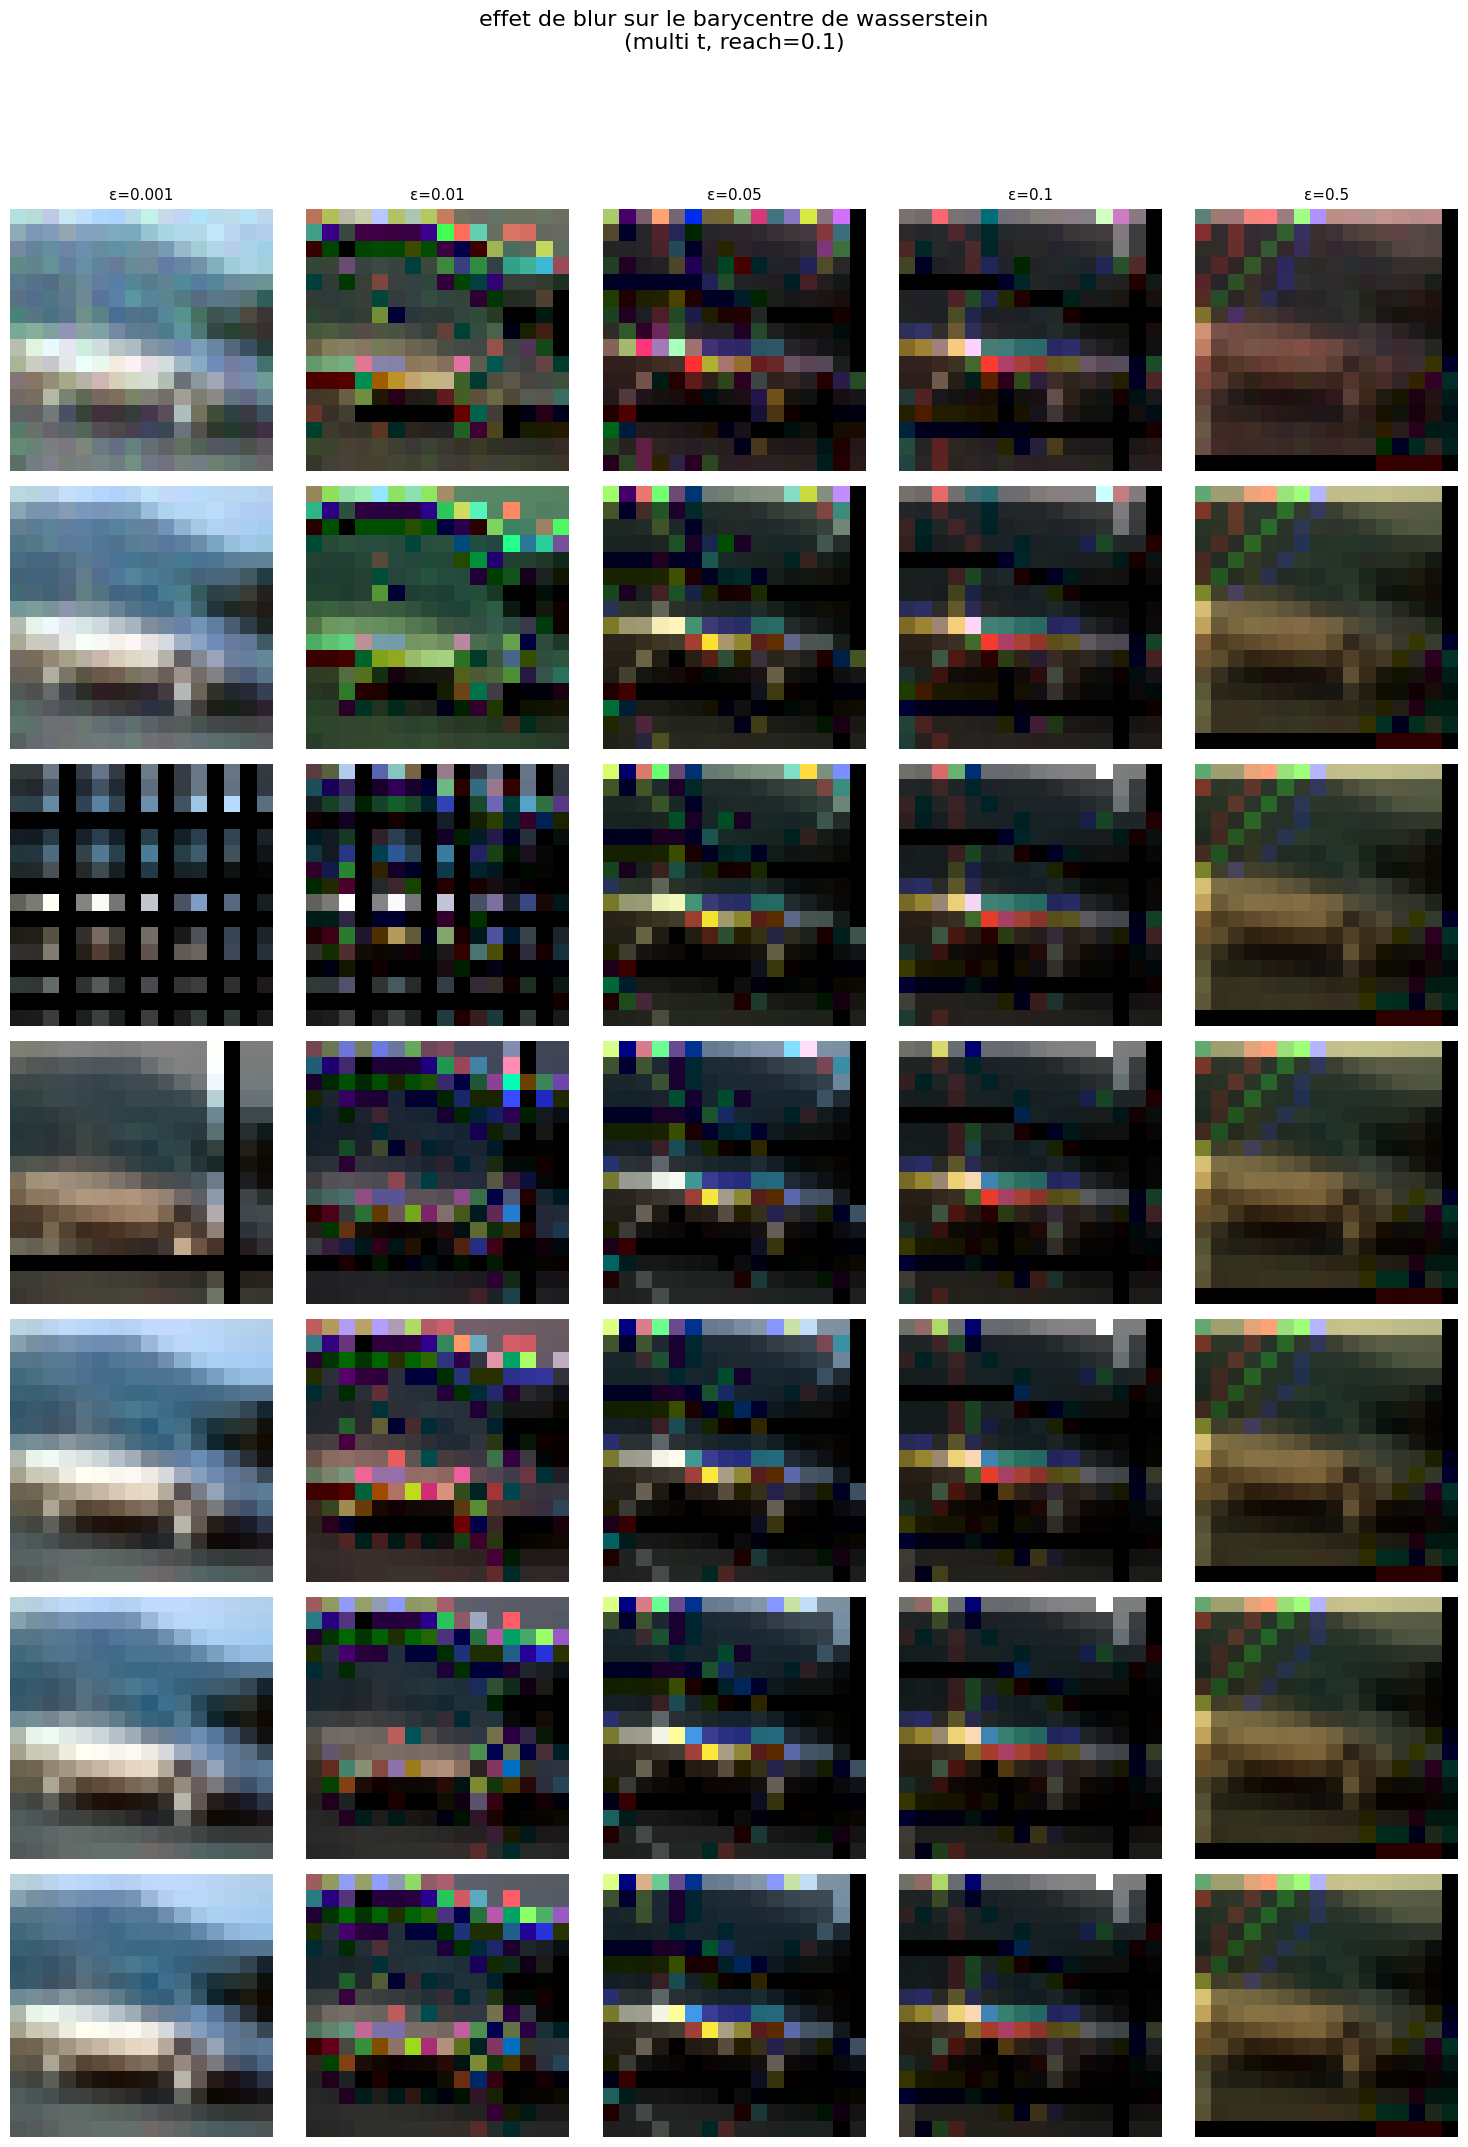


observations :
  - les images changent vraiment avec blur et t !
  - blur faible → transport très précis, détails préservés
  - blur élevé → transport plus diffus, transition plus douce
  - t proche de 1 → image presque cible
calcul des barycentres wasserstein (RGB) pour différents blur et t_mid...


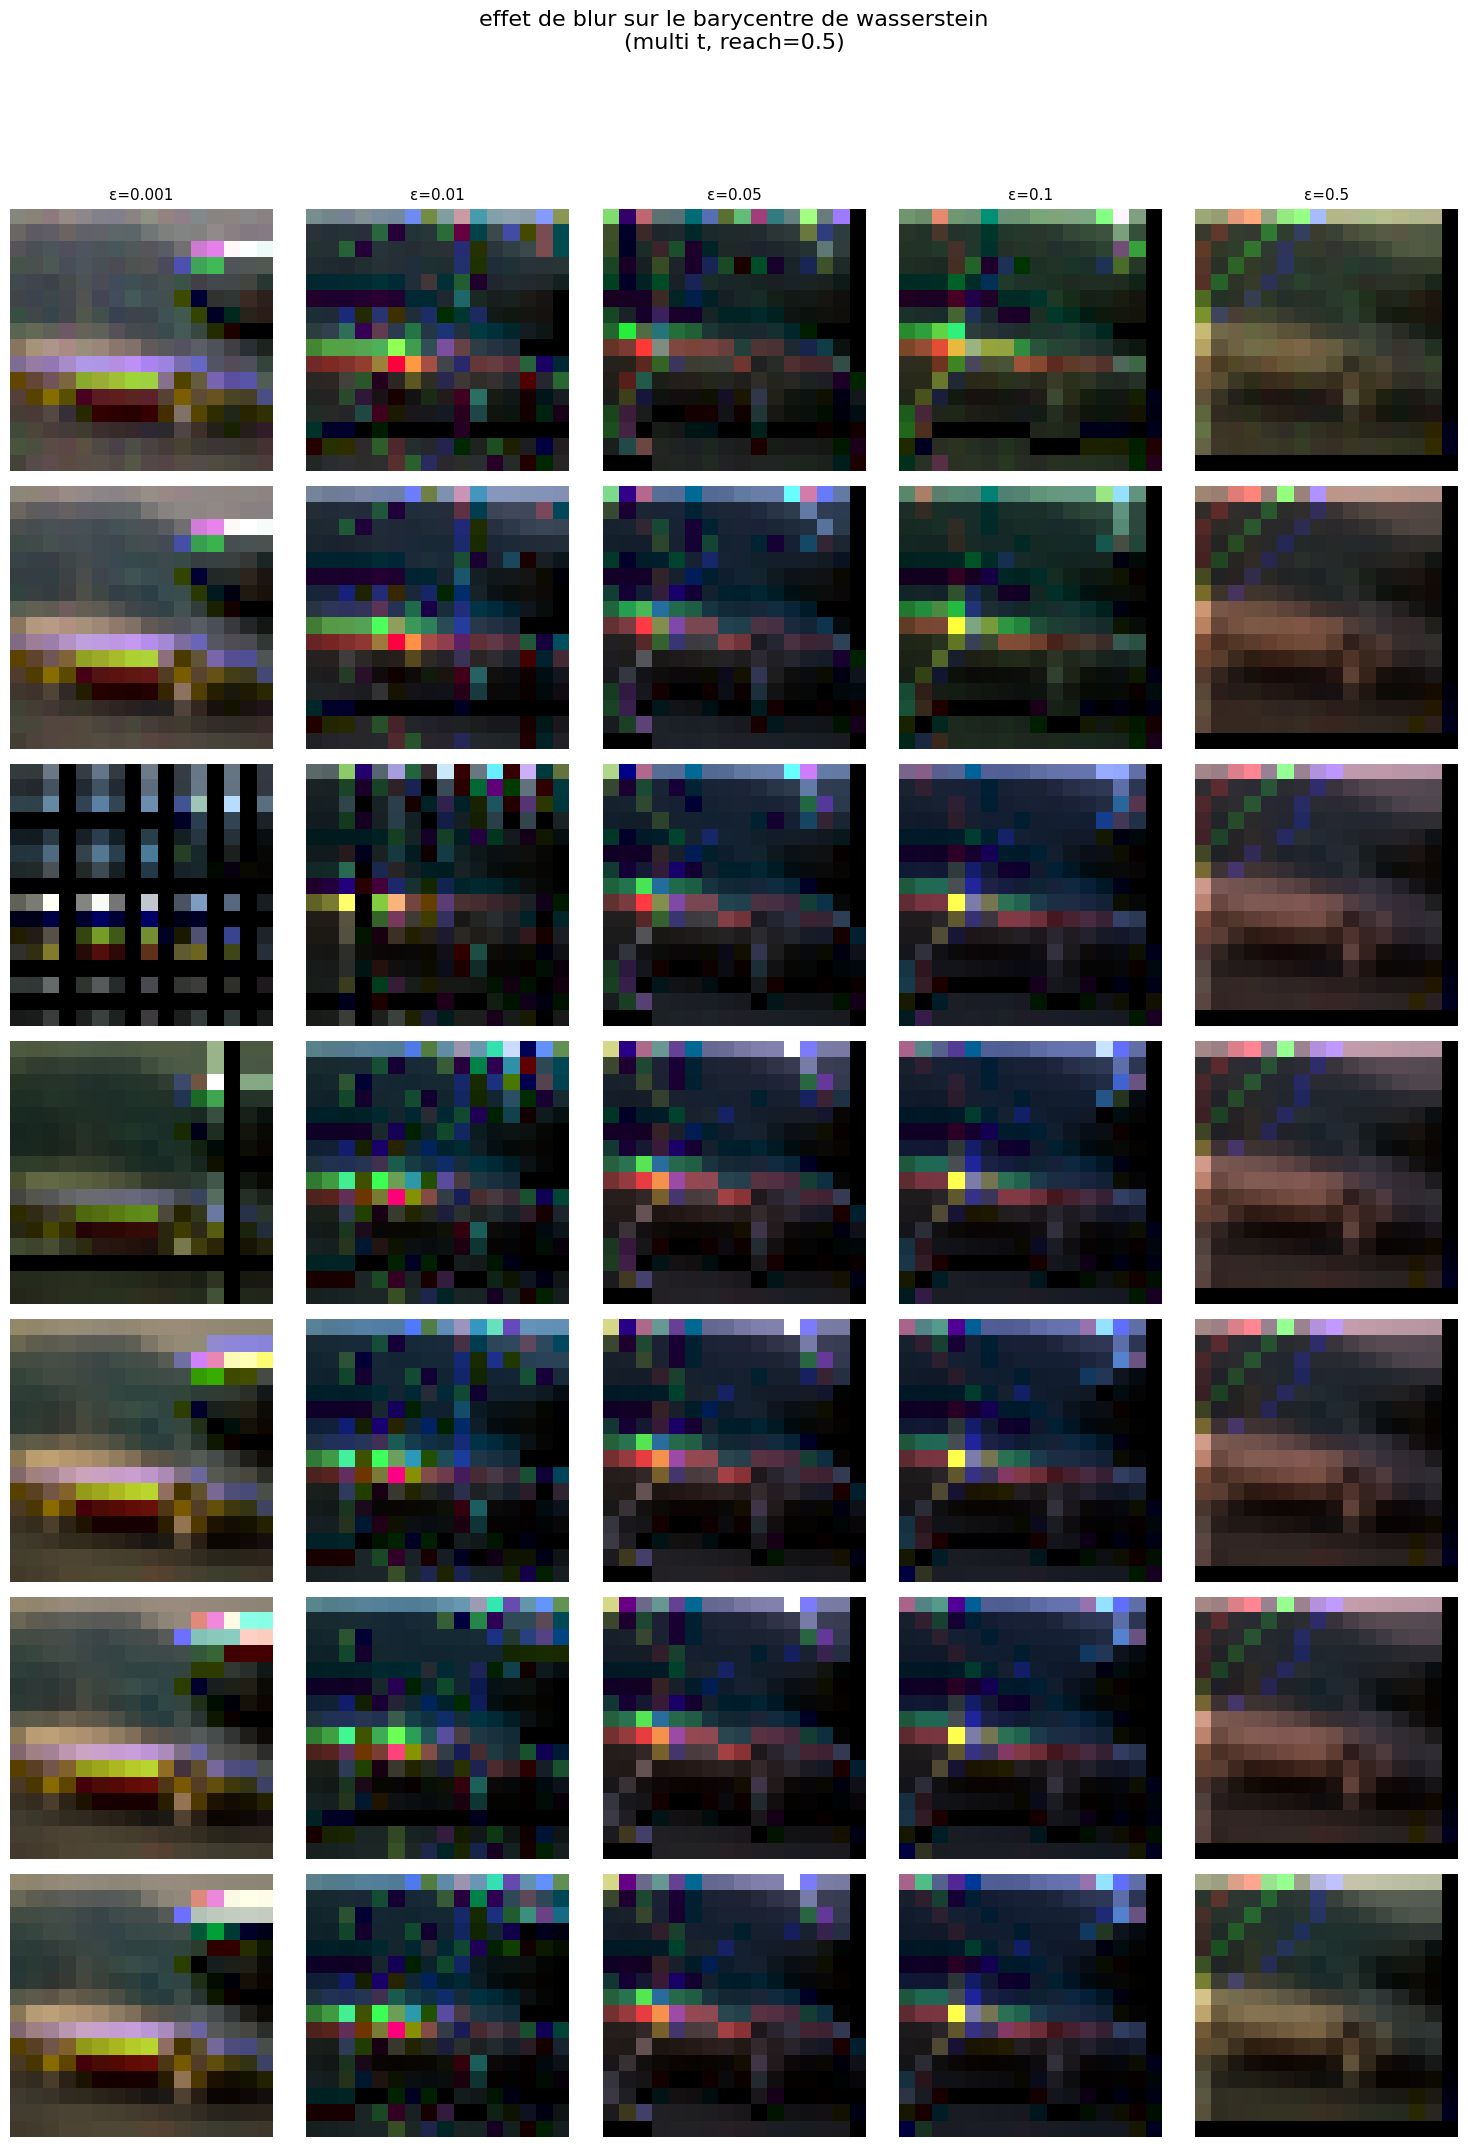


observations :
  - les images changent vraiment avec blur et t !
  - blur faible → transport très précis, détails préservés
  - blur élevé → transport plus diffus, transition plus douce
  - t proche de 1 → image presque cible


In [67]:
# we test the effect of blur on wasserstein barycenters for several t_mid
for reach_fixed_wass in [0.005, 0.01, 0.05, 0.1, 0.5]:
    blur_test_vals = [0.001, 0.01, 0.05, 0.1, 0.5]  # we test different blur values
    t_mid_vals = [0.7, 0.85, 0.9, 0.95, 0.98, 0.99, 1]  # several t values near the end

    # Create grid: rows = t_mid, cols = blur values
    fig, axes = plt.subplots(len(t_mid_vals), len(blur_test_vals), figsize=(3*len(blur_test_vals), 3*len(t_mid_vals)))
    fig.suptitle(f'effet de blur sur le barycentre de wasserstein\n(multi t, reach={reach_fixed_wass})', fontsize=16, y=1.02)

    print("calcul des barycentres wasserstein (RGB) pour différents blur et t_mid...")

    for row_idx, t_mid in enumerate(t_mid_vals):
        for col_idx, blur_val in enumerate(blur_test_vals):
            img_bary = compute_rgb_wasserstein_barycenter(
                [random_tensor, image],
                [1-t_mid, t_mid],
                H=16, W=16,
                blur=blur_val,
                reach=reach_fixed_wass
            )
            ax = axes[row_idx, col_idx] if len(t_mid_vals) > 1 else axes[col_idx]
            ax.imshow(img_bary)
            if row_idx == 0:
                ax.set_title(f'ε={blur_val}', fontsize=11)
            if col_idx == 0:
                ax.set_ylabel(f't={t_mid}', fontsize=11)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f'../results/pixelart_transport/effet_blur_t_reach_{reach_fixed_wass}.png')
    plt.show()

    print("\nobservations :")
    print("  - les images changent vraiment avec blur et t !")
    print("  - blur faible → transport très précis, détails préservés")
    print("  - blur élevé → transport plus diffus, transition plus douce")
    print("  - t proche de 1 → image presque cible")


## effet des paramètres sur les barycentres de wasserstein

### paramètre blur (epsilon) - régularisation entropique

le paramètre **blur** ($\varepsilon$) contrôle la régularisation entropique du transport optimal :

$$\min_{\pi} \langle C, \pi \rangle + \varepsilon H(\pi)$$

**effets observés** :
- **blur faible** : transport très précis et détaillé
- **blur élevé** : transport plus diffus et régularisé

### paramètre reach (rho) - transport non équilibré

le paramètre **reach** ($\rho$) contrôle la pénalité pour violer la conservation de masse :

$$\min_{\pi} \langle C, \pi \rangle + \rho \text{KL}(\pi \mathbf{1} \| \alpha) + \rho \text{KL}(\pi^T \mathbf{1} \| \beta)$$

**effets observés** :
- **reach faible** : permet création/destruction de masse
- **reach élevé** : impose conservation de masse
- **reach → ∞** : converge vers transport équilibré classique


calcul des barycentres wasserstein (RGB) pour différents reach...


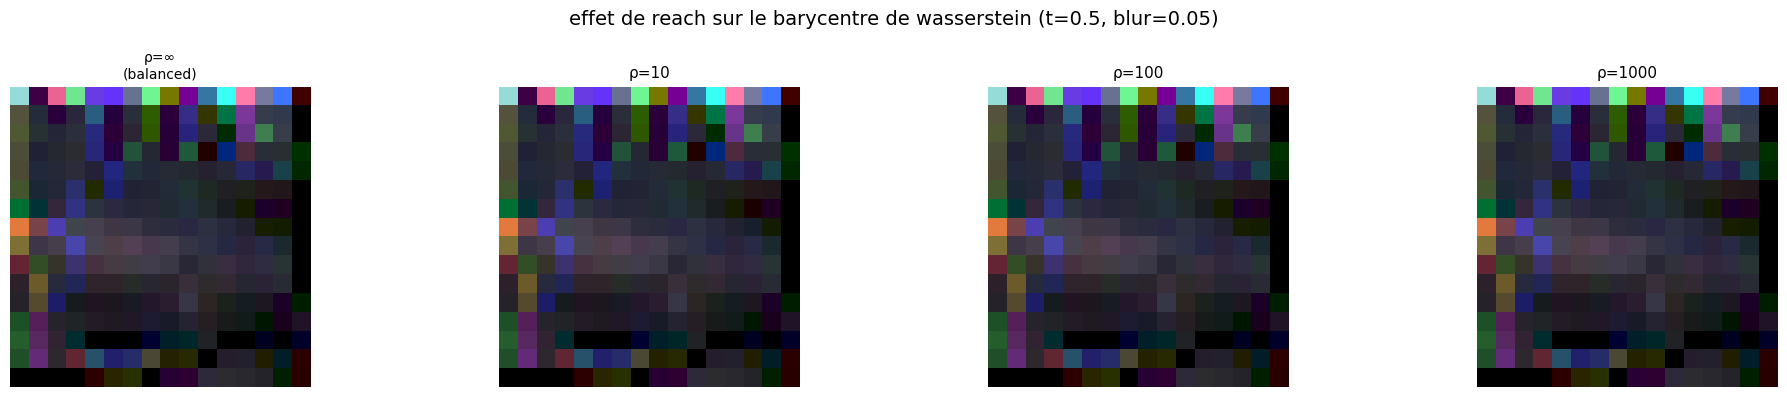


observations :
  - les images changent vraiment avec reach !
  - reach faible → permet création/destruction de masse, transition plus libre
  - reach élevé → force conservation de masse, transport plus contraint
  - reach=∞ (balanced) → transport optimal classique de wasserstein


In [56]:
# we test the effect of reach on wasserstein barycenters

reach_test_vals = [None,10,100,1000]  # we test different reach values (None = balanced)
blur_fixed_wass2 = 0.05  # we fix blur
t_mid = 0.5  # we compute barycenter at midpoint

fig, axes = plt.subplots(1, len(reach_test_vals), figsize=(20, 4))  # we create subplots
fig.suptitle(f'effet de reach sur le barycentre de wasserstein (t={t_mid}, blur={blur_fixed_wass2})', fontsize=14)

print("calcul des barycentres wasserstein (RGB) pour différents reach...")

for idx, reach_val in enumerate(reach_test_vals):  # we iterate over reach values
    # we compute wasserstein barycenter for RGB
    img_bary = compute_rgb_wasserstein_barycenter(
        [random_tensor, image],  # we target both images
        [1-t_mid, t_mid],  # we set weights for interpolation
        H=16, W=16,  # we specify dimensions
        blur=blur_fixed_wass2,
        reach=reach_val
    )
    
    # we display
    axes[idx].imshow(img_bary)
    if reach_val is None:  # we handle balanced case
        axes[idx].set_title(f'ρ=∞\n(balanced)', fontsize=10)
    else:
        axes[idx].set_title(f'ρ={reach_val}', fontsize=11)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nobservations :")
print("  - les images changent vraiment avec reach !")
print("  - reach faible → permet création/destruction de masse, transition plus libre")
print("  - reach élevé → force conservation de masse, transport plus contraint")
print("  - reach=∞ (balanced) → transport optimal classique de wasserstein")


## résumé : impact des paramètres sur le transport

### paramètre blur (epsilon) - régularisation entropique

le paramètre **blur** ($\varepsilon$) contrôle la régularisation entropique du problème :

$$\min_{\pi} \langle C, \pi \rangle + \varepsilon H(\pi)$$

où $H(\pi) = -\sum_{i,j} \pi_{ij} \log \pi_{ij}$ est l'entropie.

**effets observables** :
- **blur faible** (0.01) : transport très précis, distance plus grande, peut être instable
- **blur moyen** (0.05) : bon compromis entre précision et stabilité
- **blur élevé** (0.1+) : transport plus diffus, distance plus petite, très stable

**analogie** : blur élevé = "flouter" le plan de transport, permettant des déplacements plus larges

---

### paramètre reach (rho) - transport non équilibré

le paramètre **reach** ($\rho$) contrôle la pénalité pour violer la conservation de masse :

$$\min_{\pi} \langle C, \pi \rangle + \rho \text{KL}(\pi \mathbf{1} \| \alpha) + \rho \text{KL}(\pi^T \mathbf{1} \| \beta)$$

**effets observables** :
- **reach faible** (0.1) : permet beaucoup de création/destruction, distance plus petite
- **reach moyen** (0.5) : équilibre entre flexibilité et conservation
- **reach élevé** (5.0+) : impose strictement la conservation de masse

**analogie** : reach faible = pouvoir "créer" ou "supprimer" des pixels au lieu de les déplacer

---

### choix des paramètres en pratique

| application | blur recommandé | reach recommandé |
|-------------|-----------------|------------------|
| images similaires | 0.05 - 0.1 | 1.0 - 5.0 |
| images très différentes | 0.1 - 0.2 | 0.1 - 0.5 |
| calcul rapide | 0.1+ | 0.5 - 1.0 |
| précision maximale | 0.01 - 0.05 | 5.0+ |

---

### lien avec les modèles de diffusion

dans les modèles de diffusion d'images, le transport optimal est utilisé pour :
1. **interpoler** entre images dans l'espace latent
2. **mesurer** la qualité de génération (via distances de wasserstein)
3. **optimiser** le processus de débruitage (backward process)

le transport non équilibré est particulièrement utile quand les distributions source et cible ont des supports différents.


## vrai barycentre de wasserstein avec geomloss

maintenant, calculons un **vrai barycentre de wasserstein** en utilisant le gradient du sinkhorn pour approximer la carte de monge.

### principe

au lieu d'une interpolation linéaire, nous allons :

1. partir d'une distribution uniforme $\mu$ sur une grille
2. calculer le gradient de la divergence de sinkhorn : $\nabla_x S(\mu, \nu)$
3. utiliser ce gradient pour approximer la carte de transport : $T(x) = x - \frac{1}{a} \nabla_x S(\mu, \nu)$
4. le barycentre pour des poids $(\lambda_1, \lambda_2)$ est alors : $x_t = \lambda_1 T_1(x) + \lambda_2 T_2(x)$

cette approche donne de **vraies géodésiques dans l'espace de wasserstein** (exactes en 1D, très bonnes approximations en dimensions supérieures).


## résumé : barycentres de wasserstein

### principe des barycentres de wasserstein

les barycentres de wasserstein permettent d'interpoler entre distributions en préservant leurs structures géométriques.

**formule** : $X_t = \sum_i \lambda_i T_i(X_0)$ où $T_i$ sont les cartes de transport optimal

**propriétés** :
- dépend fortement de blur et reach
- coût computationnel modéré (calcul de gradients)
- vraie géodésique dans l'espace de wasserstein
- excellente préservation de structure

### quand utiliser les barycentres de wasserstein ?

**applications recommandées** :
- interpolation de haute qualité entre images
- génération d'images (GANs, modèles de diffusion)
- préservation de structures géométriques importantes
- analyse et comparaison de distributions
- style transfer et color transfer
- data augmentation intelligente

### formulation mathématique du barycentre

le barycentre de wasserstein approxime la solution du problème :

$$\min_{\mu} \sum_{i=1}^k \lambda_i W_p^p(\mu, \mu_i)$$

où $W_p$ est la distance de wasserstein et $\lambda_i$ sont les poids (avec $\sum \lambda_i = 1$).

l'algorithme utilisé :
1. partir d'une distribution uniforme $\mu$ sur les points sources
2. pour chaque cible $\mu_i$, calculer le gradient : $g_i = \nabla_x S(\mu, \mu_i)$
3. approximer la carte de monge : $T_i(x) = x - \frac{g_i}{a}$
4. calculer le barycentre : $X_{\text{bary}} = \sum_i \lambda_i T_i(X)$

cette approche est **exacte en dimension 1** et donne une **excellente approximation en dimensions supérieures**.

### applications en deep learning

les barycentres de wasserstein sont utilisés dans :
- **GANs** : interpolation dans l'espace latent
- **style transfer** : transfert de distributions de couleurs
- **data augmentation** : génération d'exemples intermédiaires
- **modèles de diffusion** : interpolation d'images générées


In [ ]:
# this notebook now contains only wasserstein barycenters (no linear interpolation)

print("✓ notebook complet !")
print("toutes les visualisations utilisent les vrais barycentres de wasserstein")
print("les paramètres blur et reach affectent réellement le transport optimal")


✓ notebook complet !
toutes les visualisations utilisent les vrais barycentres de wasserstein
les paramètres blur et reach affectent réellement le transport optimal
